In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"{device} is being used")

cuda is being used


In [3]:
# # different values are used for 3 diffn channels

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

### Deleting data folder if exists

In [4]:
import shutil
import os

# Define the directory path
dir_path = 'data'

# Remove the directory and all its contents
if os.path.exists(dir_path) and os.path.isdir(dir_path):
    shutil.rmtree(dir_path)
    print(f"{dir_path} folder and all its contents have been deleted.")
else:
    print(f"{dir_path} folder does not exist.")

data folder and all its contents have been deleted.


### Downloading the data

In [5]:
from urllib.request import urlretrieve
import zipfile

data_dir = "data"

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

if not os.path.exists(data_dir):
    filename = "hymenoptera_data.zip"
    urlretrieve(url, filename)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(filename)  # Clean up by removing the zip file

Purpose is to perform **Training and Validation Augmentation**

**transforms.Compose()** -> Combines multiple transformation functions into one. These transformations will be applied in sequence to the input images.

**transforms.ToTensor()**->Converts the image from a PIL image or NumPy array to a PyTorch tensor. This transformation also scales the pixel values to a range between 0 and 1

In [6]:
data_transforms = {
    "train":transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [7]:
data_dir = "data/hymenoptera_data"
sets = ['train', 'val']

image_datasets = {
    x:datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in sets
}

In [8]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 244
    Root location: data/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
dataloaders = {
    x:torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
    for x in sets
}

In [10]:
dataloaders['train']

### Viewing data

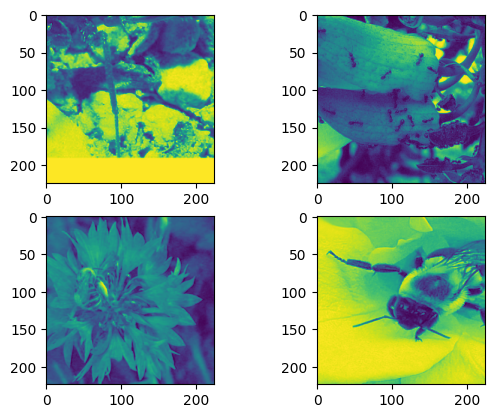

In [11]:
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i][0])
plt.show()

**transpose((1, 2, 0))**: Rearranges the dimensions of the NumPy array from [C, H, W] to [H, W, C]. This is necessary because matplotlib expects the image array to have the height and width dimensions first, followed by the channels

**std * inp + mean**: This line undoes the normalization applied to the image during preprocessing. Typically, images are normalized with a mean and standard deviation (e.g., mean and std), and this line reverses that normalization to get the image back to its original scale.

**np.clip(inp, 0, 1)**: Ensures that all pixel values in the image are within the range [0, 1]. This is useful because pixel values should be between 0 and 1 after denormalization. Clipping ensures that any values outside this range are fixed to the nearest boundary (0 or 1).


In [12]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


In [13]:
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


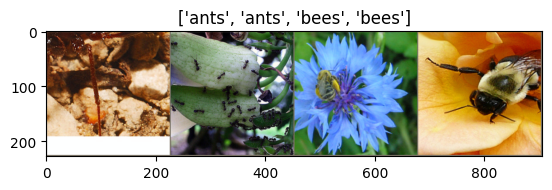

In [14]:
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in labels])

In [15]:
dataset_sizes = {x: len(image_datasets[x]) for x in sets}
print(dataset_sizes)

{'train': 244, 'val': 153}


### Define the model

**model.state_dict()**: This is a method in PyTorch that returns a dictionary containing all the model parameters (weights and biases). This dictionary maps each layer to its corresponding parameter tensor.

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs}")
        print("-"*10)

        for phase in ['train', 'val']:
            if phase=='train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # inputs shape = (4, 3, 224, 224])
            # labels shape = (4)
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # Here loss is a scalar quantity, represents the average loss per sample
                    loss = criterion(outputs, labels)

                    if phase=='train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                # To get the loss for the whole batch, we multiply it by batch_size
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Using transfer learning

##### **A. In this case, the whole layers will be trained again**

**fc** is the last layer of the model.

**(fc): Linear(in_features=512, out_features=1000, bias=True)**

****************************
Using learning rate scheduler, : At the beginning of training, we might want a higher learning rate to make rapid progress in optimizing the loss function. Towards the end, we might lower the learning rate to fine-tune the model and avoid overshooting the minima of the loss function.

In [17]:
model = models.resnet18(pretrained=True)
# Number of input features for fully connected layers
num_ftrs = model.fc.in_features

# Defining own FC layer where input_dim will the same and output dim will be 2 instead of 1000.
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Scheduler for updating the learning rate
# At every 7th epoch, lr will be multiplied by gamma
step_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/20
----------
train Loss: 0.8189 Acc: 0.6803
val Loss: 0.2388 Acc: 0.9085

Epoch 1/20
----------
train Loss: 0.7040 Acc: 0.7459
val Loss: 0.7229 Acc: 0.7712

Epoch 2/20
----------
train Loss: 0.7653 Acc: 0.7213
val Loss: 0.2388 Acc: 0.9281

Epoch 3/20
----------
train Loss: 0.5278 Acc: 0.8115
val Loss: 0.1946 Acc: 0.9346

Epoch 4/20
----------
train Loss: 0.4510 Acc: 0.8443
val Loss: 0.3935 Acc: 0.9150

Epoch 5/20
----------
train Loss: 0.5246 Acc: 0.8238
val Loss: 1.0493 Acc: 0.7255

Epoch 6/20
----------
train Loss: 0.5267 Acc: 0.8197
val Loss: 0.3663 Acc: 0.8889

Epoch 7/20
----------
train Loss: 0.3181 Acc: 0.8484
val Loss: 0.2354 Acc: 0.9281

Epoch 8/20
----------
train Loss: 0.3318 Acc: 0.8730
val Loss: 0.2080 Acc: 0.9412

Epoch 9/20
----------
train Loss: 0.3445 Acc: 0.8689
val Loss: 0.2211 Acc: 0.9346

Epoch 10/20
----------
train Loss: 0.2874 Acc: 0.8525
val Loss: 0.2209 Acc: 0.9281

Epoch 11/20
----------
train Loss: 0.2665 Acc: 0.8975
val Loss: 0.2684 Acc: 0.9150

Ep

##### **B. Only the newly added layers will be trained, rest all the layers will ramin frozen and will retain their existing weights**

In [18]:
model = models.resnet18(pretrained=True)
# Freeze all the layers
for param in model.parameters():
    param.requires_grad=False

# Number of input features for fully connected layers
num_ftrs = model.fc.in_features

# Defining own FC layer where input_dim will the same and output dim will be 2 instead of 1000.
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Scheduler for updating the learning rate
# At every 7th epoch, lr will be multiplied by gamma
step_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)


Epoch 0/20
----------
train Loss: 0.7875 Acc: 0.6352
val Loss: 0.2169 Acc: 0.9412

Epoch 1/20
----------
train Loss: 0.5108 Acc: 0.7828
val Loss: 0.4644 Acc: 0.8170

Epoch 2/20
----------
train Loss: 0.6530 Acc: 0.7418
val Loss: 0.1958 Acc: 0.9477

Epoch 3/20
----------
train Loss: 0.4576 Acc: 0.7828
val Loss: 0.1931 Acc: 0.9281

Epoch 4/20
----------
train Loss: 0.4725 Acc: 0.8156
val Loss: 0.1856 Acc: 0.9477

Epoch 5/20
----------
train Loss: 0.8684 Acc: 0.6844
val Loss: 0.2340 Acc: 0.9150

Epoch 6/20
----------
train Loss: 0.6496 Acc: 0.7705
val Loss: 0.1744 Acc: 0.9608

Epoch 7/20
----------
train Loss: 0.3369 Acc: 0.8689
val Loss: 0.1832 Acc: 0.9542

Epoch 8/20
----------
train Loss: 0.3513 Acc: 0.8566
val Loss: 0.1865 Acc: 0.9412

Epoch 9/20
----------
train Loss: 0.3156 Acc: 0.8648
val Loss: 0.1834 Acc: 0.9477

Epoch 10/20
----------
train Loss: 0.3869 Acc: 0.8443
val Loss: 0.1942 Acc: 0.9542

Epoch 11/20
----------
train Loss: 0.4041 Acc: 0.8320
val Loss: 0.1742 Acc: 0.9542

Ep